
# Регрессия на **Servo Data Set** (UCI)

EDA → простая визуализация → базовый препроцессинг → эксперименты с **Линейной регрессией (OLS)** и **Перцептроном** (однослойная регрессия через `SGDRegressor`) → подбор гиперпараметров/регуляризации для перцептрона → итоговое сравнение.


In [7]:

import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, SGDRegressor

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 1. Загрузка


In [8]:

def load_servo(path='.'):
    cols = ['motor','screw','pgain','vgain','rise_time']
    for p in [os.path.join(path, 'servo', 'servo.data'),
              os.path.join(path, 'servo.data')]:
        if os.path.exists(p):
            return pd.read_csv(p, names=cols)
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/servo/servo.data'
    return pd.read_csv(url, names=cols)

df = load_servo('.')
df.head()


,motor,screw,pgain,vgain,rise_time
0,E,E,5,4,0.281251
1,B,D,6,5,0.506252
2,D,D,4,3,0.356251
3,B,A,3,2,5.500033
4,D,B,6,5,0.356251



## 2. Анализ признаков


In [9]:

print('Размер:', df.shape)
print('\nТипы:'); print(df.dtypes)
print('\nПропуски всего:', int(df.isna().sum().sum()))
print('\nУникальные значения:')
for c in df.columns: print(f'- {c}: {df[c].nunique()}')

cat_cols = [c for c in df.columns if df[c].dtype == 'object']
num_cols = [c for c in df.columns if c not in cat_cols + ['rise_time']]
print('\nКатегориальные:', cat_cols)
print('Числовые:', num_cols)


Размер: (167, 5)

Типы:
motor         object
screw         object
pgain          int64
vgain          int64
rise_time    float64
dtype: object

Пропуски всего: 0

Уникальные значения:
- motor: 5
- screw: 5
- pgain: 4
- vgain: 5
- rise_time: 51

Категориальные: ['motor', 'screw']
Числовые: ['pgain', 'vgain']



## 3. Визуализация


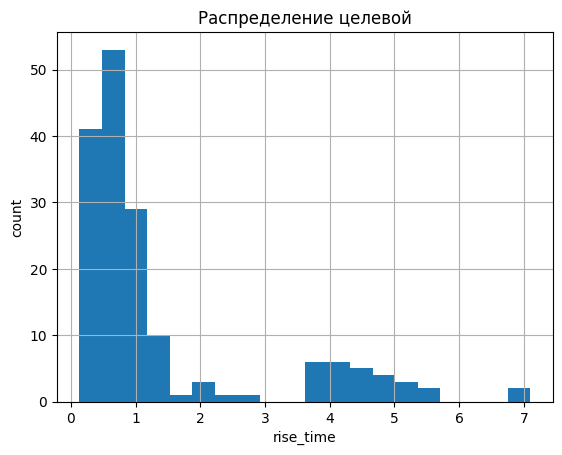

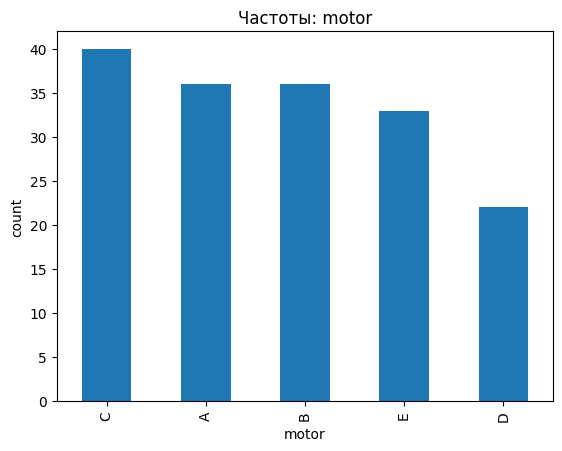

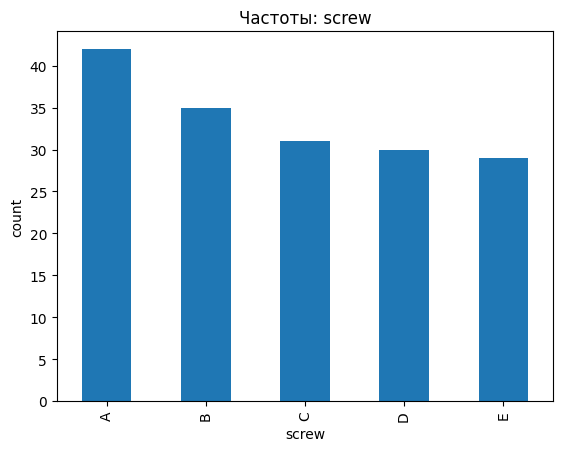

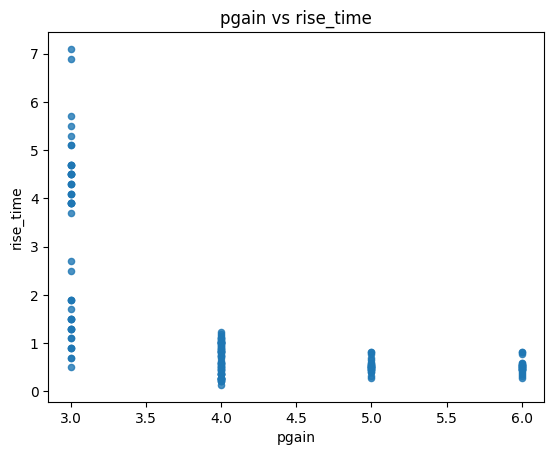

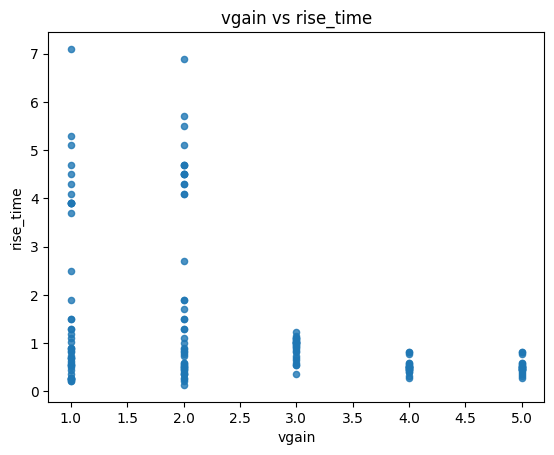

In [10]:

plt.figure(); df['rise_time'].hist(bins=20)
plt.title('Распределение целевой'); plt.xlabel('rise_time'); plt.ylabel('count'); plt.show()

for c in cat_cols:
    plt.figure(); df[c].value_counts().plot(kind='bar')
    plt.title(f'Частоты: {c}'); plt.xlabel(c); plt.ylabel('count'); plt.show()

for c in num_cols:
    plt.figure(); plt.scatter(df[c], df['rise_time'], s=20, alpha=0.8)
    plt.title(f'{c} vs rise_time'); plt.xlabel(c); plt.ylabel('rise_time'); plt.show()



## 4. Препроцессинг


In [11]:

feature_cols = [c for c in df.columns if c!='rise_time']

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ('num', StandardScaler(), num_cols)
], remainder='drop')

X = df[feature_cols]; y = df['rise_time'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


(133, 4) (34, 4)



## 5. Бейзлайн с кросс-валидацией


In [12]:

cv = KFold(n_splits=5, shuffle=True, random_state=42)

pipe_lr = Pipeline([('prep', preprocess), ('model', LinearRegression())])
pipe_sgd = Pipeline([('prep', preprocess), ('model', SGDRegressor(random_state=42, max_iter=5000, early_stopping=True))])

def cv_report(pipe, X, y, name):
    rmse = -cross_val_score(pipe, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    r2 = cross_val_score(pipe, X, y, cv=cv, scoring='r2')
    print(f'{name}: RMSE {rmse.mean():.3f}±{rmse.std():.3f} | R2 {r2.mean():.3f}±{r2.std():.3f}')

cv_report(pipe_lr, X, y, 'LinearRegression (base)')
cv_report(pipe_sgd, X, y, 'Perceptron=SGDRegressor (base)')


LinearRegression (base): RMSE 1.078±0.162 | R2 0.507±0.086
Perceptron=SGDRegressor (base): RMSE 1.202±0.157 | R2 0.392±0.058



## 6. Подбор гиперпараметров (перцептрон)


In [13]:

pipe_sgd_tune = Pipeline([('prep', preprocess),
                          ('model', SGDRegressor(random_state=42, max_iter=5000, early_stopping=True))])

param_grid = {
    'model__alpha': np.logspace(-6, -2, 5),
    'model__penalty': ['l2', 'l1', 'elasticnet'],
    'model__l1_ratio': [0.15, 0.5, 0.85]
}

gs = GridSearchCV(pipe_sgd_tune, param_grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True)
gs.fit(X_train, y_train)
print('Best params:', gs.best_params_)
print('Best CV RMSE:', -gs.best_score_)
best_sgd = gs.best_estimator_


Best params: {'model__alpha': np.float64(0.01), 'model__l1_ratio': 0.15, 'model__penalty': 'l1'}
Best CV RMSE: 1.2521132449259595



## 7. Итоговая оценка на тесте


[LinearRegression (OLS)] MAE=0.765 RMSE=0.929 R2=0.643


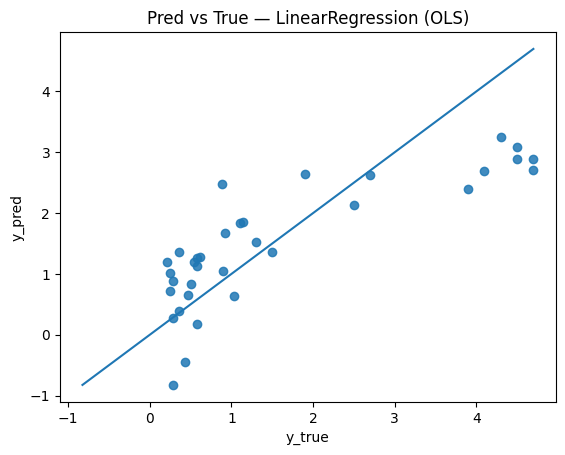

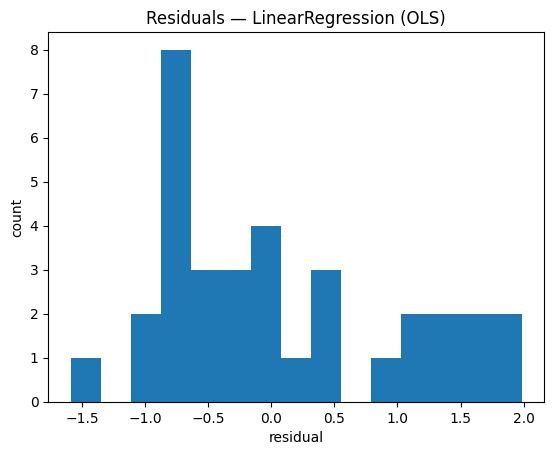

[Perceptron (SGDRegressor tuned)] MAE=0.852 RMSE=1.023 R2=0.567


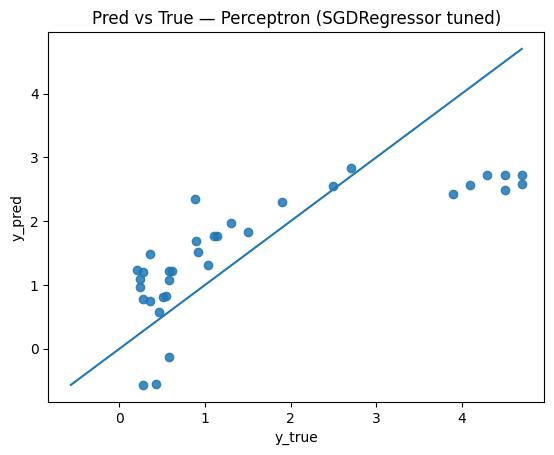

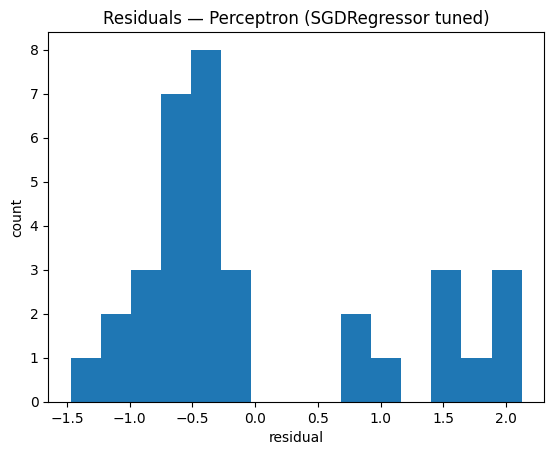

,MAE,RMSE,R2
model,,,
LinearRegression (OLS),0.765,0.929,0.643
Perceptron (SGDRegressor tuned),0.852,1.023,0.567


In [15]:

def evaluate(model, name):
    model.fit(X_train, y_train)
    p = model.predict(X_test)
    mae = mean_absolute_error(y_test, p)
    mse = mean_squared_error(y_test, p)
    rmse = np.sqrt(mse)

    r2 = r2_score(y_test, p)
    print(f'[{name}] MAE={mae:.3f} RMSE={rmse:.3f} R2={r2:.3f}')
    # графики
    plt.figure(); plt.scatter(y_test, p, alpha=0.85); lims=[min(y_test.min(), p.min()), max(y_test.max(), p.max())]
    plt.plot(lims, lims); plt.title(f'Pred vs True — {name}'); plt.xlabel('y_true'); plt.ylabel('y_pred'); plt.show()
    plt.figure(); plt.hist(y_test - p, bins=15); plt.title(f'Residuals — {name}'); plt.xlabel('residual'); plt.ylabel('count'); plt.show()
    return {'model':name,'MAE':mae,'RMSE':rmse,'R2':r2}

res = []
res.append(evaluate(pipe_lr, 'LinearRegression (OLS)'))
res.append(evaluate(best_sgd, 'Perceptron (SGDRegressor tuned)'))
pd.DataFrame(res).set_index('model').round(3)



## 8. Короткий вывод
- Линейная регрессия даёт простой ориентир без регуляризации.  
- Перцептрон (через SGDRegressor) позволяет настраивать **L1/L2/ElasticNet** и параметр `alpha`, что даёт контроль над переобучением после OneHot.  
- На малом датасете результаты могут заметно колебаться между фолдами; масштабирование и аккуратная сетка по `alpha` — критичны.
